Compare model wind speed with measurements

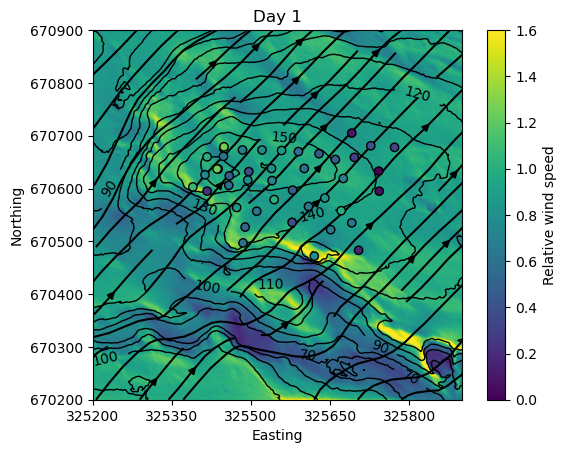

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from osgeo import gdal
from scipy.interpolate import interpn

# contour map
gdal.UseExceptions()
ds = gdal.Open('Blackford_2M_DTM_PHASE5.tif')
xul, dx, _, yul, _, _ = ds.GetGeoTransform()
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
ny, nx = z.shape
x = xul + np.arange(nx)*dx
y = yul - (ny - np.arange(ny))*dx
cs = plt.contour(x,y,z,colors='k',levels=np.arange(0,200,10),linewidths=1)
plt.clabel(cs,fmt='%d')
plt.xlim(325200,325900)
plt.ylim(670200,670900) 
plt.xlabel('Easting')
plt.ylabel('Northing')

# WindNinja flow lines
vel = np.loadtxt('Blackford_2M_DTM_PHASE5_225_1_2m_vel.asc',skiprows=6)[:ny,:nx]
ang = np.loadtxt('Blackford_2M_DTM_PHASE5_225_1_2m_ang.asc',skiprows=6)[:ny,:nx]
vel = vel[::-1,:]
ang = ang[::-1,:]
u = - vel*np.sin(np.radians(ang))
v = - vel*np.cos(np.radians(ang))
summit = np.array((325437,670639))
points = (x,y)
vel = vel/interpn(points,vel,summit)
plt.streamplot(x,y,u,v,color='k')
plt.imshow(vel,extent=(x.min(),x.max(),y.min(),y.max()),origin='lower',vmin=0,vmax=1.6)
plt.colorbar(label = 'Relative wind speed')

# measurements
df = pd.read_csv('BlackfordWindDataFull.csv')

# wind speeds from anemometer counts with June 1999 calibration
mcount = [2.29, 2.4474, 2.49]
df['a_speed1'] = df['ANEMOMETER 986 #TURNS'] * mcount[0] / 60 
df['a_speed2'] = df['ANEMOMETER 1280 #TURNS'] * mcount[2] / 60 

# anemometer wind speeds relative to summit Kestrel
df['a_speed1'] = df['a_speed1'] / df['KESTREL WINDSPEED']
df['a_speed2'] = df['a_speed2'] / df['KESTREL WINDSPEED']

# anemometer locations coloured by relative wind speed
xa = np.concatenate((df['ANEMOMETER 986 LAT'], df['ANEMOMETER 1280 LAT'])) + 300000
ya = np.concatenate((df['ANEMOMETER 986 LON'], df['ANEMOMETER 1280 LON'])) + 600000
Ua = np.concatenate((df['a_speed1'], df['a_speed2']))
plt.scatter(xa,ya,c=Ua,edgecolors='k',vmin=0.2,vmax=1.6,zorder=3)
plt.xticks(np.arange(325200, 325900, 150))
plt.title('Day 1')

# model wind speed at valid measurement points
xa = xa[~np.isnan(xa)]
ya = ya[~np.isnan(ya)]
Ua = Ua[~np.isnan(Ua)]
Um = interpn(points,vel,(xa,ya))